### **BPIC 2012 - W_Calling after sent offers**


In [8]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from data.processor import *
from data.args import *

from tensorflow.keras.utils import to_categorical

### Define the experiment parameters

In [9]:
milestone = 'W_Calling after sent offers' #,'All'
experiment =  'OHE'#'Standard'#'OHE', 'No_loops'
timelapsed = 'total' #'total', 'incremental'
n_size = 5

### Setting up the key parameters


In [10]:
# For local environment only
MY_WORKSPACE_DIR = os.path.join(os.getcwd(),'BPIC12')
MILESTONE_DIR = os.path.join(os.path.join(MY_WORKSPACE_DIR, milestone),experiment)

In [11]:
args = get_parameters('bpic12', MILESTONE_DIR, MY_WORKSPACE_DIR, milestone, experiment,n_size)

### Data Preprocessing

In [12]:
if milestone == 'All':
  log_df = pd.read_csv(args['file_name_all'])
  log_df = log_df.reset_index(drop=True)
else:
  log_df = pd.read_csv(args['file_name'])
  log_df = log_df.reset_index(drop=True)

if timelapsed == 'incremental':
  log_df['timelapsed'] = log_df['timelapsed_2']

log_df.head()

prefix_id  caseid               task      role                end_timestamp  \
0  173898_3  173898        A_SUBMITTED  role_112  2011-10-03 00:05:39.8170000   
1  173898_2  173898        A_SUBMITTED  role_112  2011-10-03 00:05:39.8170000   
2  173898_4  173898        A_SUBMITTED  role_112  2011-10-03 00:05:39.8170000   
3  173898_3  173898  A_PARTLYSUBMITTED  role_112  2011-10-03 00:05:40.0090000   
4  173898_2  173898  A_PARTLYSUBMITTED  role_112  2011-10-03 00:05:40.0090000   

                   trace_start  timelapsed                next_activity  \
0  2011-10-03 00:05:39.8170000           0  W_Calling after sent offers   
1  2011-10-03 00:05:39.8170000           0                   A_ACCEPTED   
2  2011-10-03 00:05:39.8170000           0                  O_CANCELLED   
3  2011-10-03 00:05:39.8170000           0  W_Calling after sent offers   
4  2011-10-03 00:05:39.8170000           0                   A_ACCEPTED   

                                      milestone  milestone_id  task_index  \
0  W_Filling in information for the application             3           1   
1  W_Filling in information for the application             2           1   
2                   W_Calling after sent offers             4           1   
3  W_Filling in information for the application             3           2   
4  W_Filling in information for the application             2           2   

   timelapsed_2  
0             0  
1             0  
2             0  
3             0  
4             0

Milestone Extraction

We expect to filter the prefixes by the milestone, and train the model for each milestone separately to observe if there will be an improvement in the model explainability as well as performance


In [13]:
if milestone != 'All':
  log_df = log_df[log_df['milestone'] == milestone]

#### Data Analysis

Balancing the dataset


In [14]:
def balance(df):
  # Dictonary with the mapping of columns
  
  #based on the paper : BPIC_2012 Winner, DOI: 10.1007/978-3-642-36285-9_24

  group_dict = {'A_ACCEPTED':'A_ACCEPTED',    
    'A_ACTIVATED' :   'A_APPROVED_ACTIVATED',
    'A_APPROVED':  'A_APPROVED_ACTIVATED',
    'A_CANCELLED': 'A_CANCELLED_DECLINED' ,
    'A_DECLINED': 'A_CANCELLED_DECLINED' ,
    'A_PARTLYSUBMITTED': 'REDUNDANT',
    'A_PREACCEPTED':'A_PREACCEPTED',
    'A_REGISTERED' : 'REDUNDANT',
    'O_ACCEPTED' : 'REDUNDANT',
    'O_CANCELLED' :  'O_CANCELLED_DECLINED' ,
    'O_CREATED':'REDUNDANT',
    'O_DECLINED' :'O_CANCELLED_DECLINED' ,
    'O_SELECTED' : 'REDUNDANT', 
    'O_SENT':'O_SENT',
    'O_SENT_BACK' : 'O_SENT_BACK',
    'W_Afhandelen leads' :  'W_Afhandelen leads',
    'W_Completeren aanvraag': 'W_Completeren aanvraag',
    'W_Filling in information for the application':'W_Filling in information for the application',
    'W_Calling after sent offers':'W_Calling after sent offers',
    'W_Assessing the application' : 'W_Assessing the application'}


  df['next_activity'].replace(group_dict, inplace=True)
  #Dropping the minority classes
  df = df.drop(df[df.next_activity == 'REDUNDANT'].index)
 

  return df

In [15]:
log_df = balance(log_df)

#replacing empty cells of categorical columns with 'none'
log_df = log_df.fillna('none')

In [16]:
#removing a minority target
log_df = log_df.drop(log_df[log_df.next_activity == 'W_Filling in information for the application'].index)

#### Data Encoding and Vectorization

Index creating for data encoding
Function : `create_index(log_df, column)`, Author: Manuel Camargo, Edited by: Bemali Wickramanayake

In [17]:
# Index creation for activity
ac_index = create_index(log_df, 'task')
index_ac = {v: k for k, v in ac_index.items()}

# Index creation for unit
rl_index = create_index(log_df, 'role')
index_rl = {v: k for k, v in rl_index.items()}

# Index creation for next activity
ne_index = create_index(log_df, 'next_activity')
index_ne = {v: k for k, v in ne_index.items()}

#mapping the dictionary values as columns in the dataframe
log_df['ac_index'] = log_df['task'].map(ac_index)
log_df['rl_index'] = log_df['role'].map(rl_index)
log_df['ne_index'] = log_df['next_activity'].map(ne_index)

log_df.head()

prefix_id  caseid                                          task  \
2   173898_4  173898                                   A_SUBMITTED   
5   173898_4  173898                             A_PARTLYSUBMITTED   
8   173898_4  173898                                 A_PREACCEPTED   
11  173898_4  173898                        W_Fixing incoming lead   
14  173898_4  173898  W_Filling in information for the application   

          role                end_timestamp                  trace_start  \
2     role_112  2011-10-03 00:05:39.8170000  2011-10-03 00:05:39.8170000   
5     role_112  2011-10-03 00:05:40.0090000  2011-10-03 00:05:39.8170000   
8   role_10889  2011-10-03 17:37:05.9680000  2011-10-03 00:05:39.8170000   
11  role_10889  2011-10-03 17:37:07.2610000  2011-10-03 00:05:39.8170000   
14    role_000  2011-10-03 21:58:22.0150000  2011-10-03 00:05:39.8170000   

    timelapsed         next_activity                    milestone  \
2            0  O_CANCELLED_DECLINED  W_Calling after sent offers   
5            0  O_CANCELLED_DECLINED  W_Calling after sent offers   
8           17  O_CANCELLED_DECLINED  W_Calling after sent offers   
11          17  O_CANCELLED_DECLINED  W_Calling after sent offers   
14          21  O_CANCELLED_DECLINED  W_Calling after sent offers   

    milestone_id  task_index  timelapsed_2  ac_index  rl_index  ne_index  
2              4           1             0         6        52         2  
5              4           2             0         4        52         2  
8              4           3            17         5        17         2  
11             4           4             0        15        17         2  
14             4           5             4        14         1         2

Splitting the dataframe into test and train sets

Function : `split_train_test(df, percentage)`, Author: Bemali Wickramanayake

In [18]:
# Split validation datasets
log_df_train, log_df_test = split_train_test(log_df, 0.3) # 70%/30%

Normalize Numerical Features

Function : `normalize_events(log_df,args,numerical_features)`, Author: Manuel Camargo, Edited by: Bemali Wickramanayake


In [19]:
numerical_features = ['timelapsed']
log_df_train = normalize_events(log_df_train,args,numerical_features)
log_df_test = normalize_events(log_df_test,args,numerical_features)

In [20]:
training_traces = len(log_df_train['prefix_id'].unique())
test_traces = len(log_df_test['prefix_id'].unique())

print('Number of traces in training set is:'+str(training_traces))
print('Number of traces in test set is:'+str(test_traces))

Number of traces in training set is:5108
Number of traces in test set is:2189


Reformat events: converting the dataframe into a dictionary to aid vectorization

Function : `reformat_events(log_df, ac_index, rl_index,ne_index)`, Author: Renuka Sindagatta/ Manuel Camargo, Edited by: Bemali Wickramanayake




In [21]:
log_train = reformat_events(log_df_train, ac_index, rl_index,ne_index)
log_test = reformat_events(log_df_test, ac_index, rl_index,ne_index)

Vectorization: Convert the data dictionaries into trainable multi dimensional tensors

Function: `vectorization(log,ac_index, rl_index, ne_index,trc_len,cases)` , Author: Bemali Wickramanayake, Inspired by the code of: Renuka Sindagatta





In [22]:
#Obtain the maximum trc_len and cases for each set
trc_len_train, cases_train = lengths(log_train)
trc_len_test, cases_test = lengths(log_test)

trc_len = max([trc_len_train, trc_len_test])
print("trace_length: "+str(trc_len)+", training cases: "+str(cases_train)+", test cases: "+str(cases_test) )

trace_length: 60, training cases: 5109, test cases: 2190


converting the training log (dictionary) into a Tensor

In [23]:
vec_train = vectorization(log_train,ac_index, rl_index, ne_index,trc_len,cases_train)
vec_test = vectorization(log_test,ac_index, rl_index, ne_index,trc_len,cases_test)

#### Generating Initial Embedding Weights for shared Model

In [24]:
ac_weights = to_categorical(sorted(index_ac.keys()), num_classes = len(ac_index))
ac_weights[0] = 0 # embedding weights for label none = 0

rl_weights =  to_categorical(sorted(index_rl.keys()), num_classes = len(rl_index))
rl_weights[0] = 0 # embeddig weights for label none = 0

#### Saving the Processed Tensor and Other Support Data

In [25]:
# saving the processed tensor
dirname = os.path.dirname(args['processed_training_vec'])

if not os.path.exists(dirname):
    os.makedirs(dirname)

with open(args['processed_training_vec'], 'wb') as fp:
    pickle.dump(vec_train, fp, protocol=pickle.HIGHEST_PROTOCOL)
with open(args['processed_test_vec'], 'wb') as fp:
    pickle.dump(vec_test, fp, protocol=pickle.HIGHEST_PROTOCOL)


# converting the weights into a dictionary and saving
weights = {'ac_weights':ac_weights, 'rl_weights':rl_weights, 'next_activity':len(ne_index)}
with open(args['weights'], 'wb') as fp:
    pickle.dump(weights, fp, protocol=pickle.HIGHEST_PROTOCOL)

# converting the weights into a dictionary and saving
indexes = {'index_ac':index_ac, 'index_rl':index_rl,'index_ne':index_ne}
with open(args['indexes'], 'wb') as fp:
    pickle.dump(indexes, fp, protocol=pickle.HIGHEST_PROTOCOL)

# converting the weights into a dictionary and saving
pre_index = {'ac_index':ac_index, 'rl_index':rl_index,'ne_index':ne_index}
with open(args['pre_index'], 'wb') as fp:
    pickle.dump(pre_index, fp, protocol=pickle.HIGHEST_PROTOCOL)

#saving the arguements (args)
with open(args['args'], 'wb') as fp:
    pickle.dump(args, fp, protocol=pickle.HIGHEST_PROTOCOL)


### Experiments

#### Load the Required Libraries

In [26]:
import os
import pickle
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import callbacks, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model

import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from pyflowchart import *
import plotly.express as px

from models.shared import *
from models.specialised import *
from models.explain import *

#### Load the Required Parameters

In [27]:
with open(args['processed_training_vec'], 'rb') as fp:
    vec_train = pickle.load(fp)
with open(args['processed_test_vec'], 'rb') as fp:
    vec_test = pickle.load(fp)
    
with open(args['weights'], 'rb') as fp:
    weights = pickle.load(fp)
ac_weights = weights['ac_weights']
rl_weights = weights['rl_weights']
next_activity = weights['next_activity']

with open(args['indexes'], 'rb') as fp:
    indexes = pickle.load(fp)
    index_ac = indexes['index_ac']
    index_rl = indexes['index_rl']
    index_ne = indexes['index_ne']

with open(args['pre_index'], 'rb') as fp:
    pre_index = pickle.load(fp)
    ac_index = pre_index['ac_index']
    rl_index = pre_index['rl_index']
    ne_index = pre_index['ne_index']

#### shared Model : (Sindhagatta et al, 2020) DOI: https://doi.org/10.1007/978-3-030-58666-9_15

In [28]:
shared = shared_model(vec_train, weights, indexes, pre_index, args)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [29]:
shared.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
shared.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ac_input (InputLayer)          [(None, 5)]          0           []                               
                                                                                                  
 rl_input (InputLayer)          [(None, 5)]          0           []                               
                                                                                                  
 ac_embedding (Embedding)       (None, 5, 16)        256         ['ac_input[0][0]']               
                                                                                                  
 rl_embedding (Embedding)       (None, 5, 66)        4356        ['rl_input[0][0]']               
                                                                                              

In [30]:
batch_size = 256 # 32, 64, 128, 256
epochs = 100

In [31]:
shared_history = shared_model_fit(vec_train, shared, indexes, pre_index, MY_WORKSPACE_DIR, batch_size, epochs, args)

Epoch 1/100
17/17 [==============================] - 24s 386ms/step - loss: 1.6035 - accuracy: 0.3814 - val_loss: 1.5748 - val_accuracy: 0.6023 - lr: 0.0010
Epoch 2/100
17/17 [==============================] - 2s 99ms/step - loss: 1.5474 - accuracy: 0.4770 - val_loss: 1.4656 - val_accuracy: 0.6506 - lr: 0.0010
Epoch 3/100
17/17 [==============================] - 2s 96ms/step - loss: 1.4108 - accuracy: 0.5737 - val_loss: 1.2200 - val_accuracy: 0.7523 - lr: 0.0010
Epoch 4/100
17/17 [==============================] - 2s 99ms/step - loss: 1.2288 - accuracy: 0.6244 - val_loss: 1.0286 - val_accuracy: 0.7679 - lr: 0.0010
Epoch 5/100
17/17 [==============================] - 2s 95ms/step - loss: 1.1026 - accuracy: 0.6327 - val_loss: 0.9158 - val_accuracy: 0.7692 - lr: 0.0010
Epoch 6/100
17/17 [==============================] - 2s 95ms/step - loss: 1.0285 - accuracy: 0.6327 - val_loss: 0.8551 - val_accuracy: 0.7718 - lr: 0.0010
Epoch 7/100
17/17 [==============================] - 2s 95ms/step - 

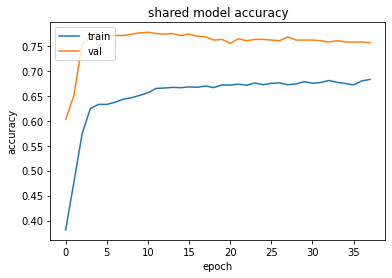

In [32]:
plot_shared(shared_history)

In [ ]:
# trained_model = os.path.join(os.path.join(MILESTONE_DIR, 'trained_models'),'shared_model.h5')
# shared.save(trained_model)

##### Load Saved Model and Evaluate

In [ ]:
# shared_trained_model = os.path.join(os.path.join(MILESTONE_DIR, 'trained_models'),'shared_model.h5')
# shared_model = load_model(shared_trained_model)

In [33]:
x_test,y_test = generate_inputs_shared(vec_test,args,indexes)

print("Evaluate on test data")

results = shared.evaluate(x_test, y_test, batch_size=100)
y_pred_shared = shared.predict(x_test)
print("test loss, test acc:", results)

Evaluate on test data
69/69 [==============================] - 6s 9ms/step
test loss, test acc: [0.8978462219238281, 0.6557077765464783]


Classification Report

In [34]:
target_names = [index_ne[i] for i in range(len(index_ne))]

print(classification_report(y_test.argmax(axis=1), y_pred_shared.argmax(axis=1), target_names=target_names))

                             precision    recall  f1-score   support

       A_APPROVED_ACTIVATED       0.00      0.00      0.00        74
       A_CANCELLED_DECLINED       0.35      0.17      0.23       308
       O_CANCELLED_DECLINED       0.33      0.15      0.20       383
                O_SENT_BACK       0.68      0.88      0.76       797
W_Assessing the application       0.75      0.99      0.86       628

                   accuracy                           0.66      2190
                  macro avg       0.42      0.44      0.41      2190
               weighted avg       0.57      0.66      0.59      2190



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion Matrix

[[  0   0   0   0  74]
 [  0  52  60 141  55]
 [  0  59  57 197  70]
 [  0  32  58 703   4]
 [  0   4   0   0 624]]


<Axes: >

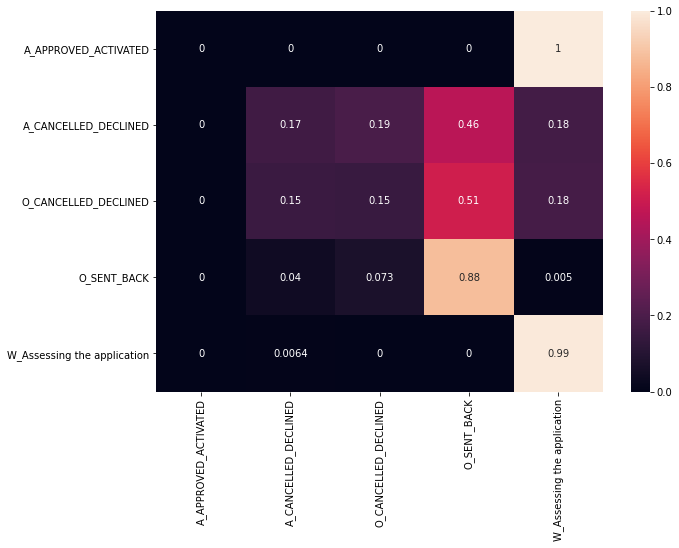

In [35]:
matrix = confusion_matrix(y_test.argmax(axis=1), y_pred_shared.argmax(axis=1))
print(matrix)
matrix_sum = np.sum(matrix, axis=1).reshape(-1,1)
matrix_perc = matrix / matrix_sum
df_cm = pd.DataFrame(matrix_perc, index = [index_ne[i] for i in range(len(index_ne))],
                  columns = [index_ne[i] for i in range(len(index_ne))])

plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

##### Generating Explanations with Attention Layer

In [36]:
shared_model_attn_weights = Model(inputs=shared.input,
              outputs=[shared.output, shared.get_layer('timestep_attention').output, shared.get_layer('feature_importance').output])

shared_output_with_attention = shared_model_attn_weights.predict(x_test)

69/69 [==============================] - 6s 10ms/step


###### Global Explanations

In [37]:
shared_explain_global(shared_output_with_attention,x_test,y_test,index_ac,index_rl,3,prediction = 2)

/Users/gijstoemen/Downloads/MSc_DS_AI/Year_2/Q1/Seminar/Replication/Shared-and-Specialised-Attention-based-Interpretable-Models-master/models/explain.py:86: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ind_ac = int(s.mode(activity.T[i])[0])
/Users/gijstoemen/Downloads/MSc_DS_AI/Year_2/Q1/Seminar/Replication/Shared-and-Specialised-Attention-based-Interpretable-Models-master/models/explain.py:87: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will be

###### Local Explanations

In [38]:
df_results_shared = results_df(y_test,y_pred_shared,index_ne)
df_results_shared [(df_results_shared ['prediction'] == 'O_SENT_BACK') & (df_results_shared ['pred_class'] == False) & (df_results_shared ['prediction_prob'] >=0.7) ].head(3)

sample_index   prediction          ground_truth  prediction_prob  \
29            29  O_SENT_BACK  A_CANCELLED_DECLINED           0.7659   
45            45  O_SENT_BACK  O_CANCELLED_DECLINED           0.7997   
53            53  O_SENT_BACK  O_CANCELLED_DECLINED           0.8172   

    pred_class  
29       False  
45       False  
53       False

In [39]:
shared_explain_local(shared_output_with_attention,x_test,y_test,index_ac, index_rl, index_ne, 3,53) #53 false, #1 true

prediction: O_SENT_BACK
ground truth: O_CANCELLED_DECLINED
prediction probability:0.8172


process flowchart
st0=>start: start O_SENT_role:role_11169
op1=>operation: W_Filling in information for the application_role:role_11169
op2=>operation: W_Calling after sent offers_role:role_11119
op3=>operation: W_Calling after sent offers_role:role_11119
op4=>operation: W_Calling after sent offers_role:role_10982

st0->op1
op1->op2
op2->op3
op3->op4





#### specialised Model

In [40]:
specialised = specialised_model(vec_train, weights, indexes, pre_index, args)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [41]:
specialised.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [42]:
specialised.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ac_input (InputLayer)          [(None, 5, 16)]      0           []                               
                                                                                                  
 rl_input (InputLayer)          [(None, 5, 66)]      0           []                               
                                                                                                  
 t_input (InputLayer)           [(None, 5, 1)]       0           []                               
                                                                                                  
 beta_ac (Bidirectional)        (None, 5, 100)       26800       ['ac_input[0][0]']               
                                                                                            

In [43]:
batch_size = 256 # 32, 64, 128, 256
epochs = 100

In [44]:
specialised_history = specialised_model_fit(vec_train, specialised, indexes, pre_index, MY_WORKSPACE_DIR, batch_size, epochs, args)

This is the output file path  /Users/gijstoemen/Downloads/MSc_DS_AI/Year_2/Q1/Seminar/Replication/Shared-and-Specialised-Attention-based-Interpretable-Models-master/BPIC12/models/model_specialised_W_Calling after sent offers_{epoch:02d}-{val_loss:.2f}.h5
Epoch 1/100
17/17 [==============================] - 63s 784ms/step - loss: 1.6064 - accuracy: 0.3724 - val_loss: 1.5722 - val_accuracy: 0.5580 - lr: 0.0010
Epoch 2/100
17/17 [==============================] - 2s 146ms/step - loss: 1.5713 - accuracy: 0.4530 - val_loss: 1.5162 - val_accuracy: 0.6102 - lr: 0.0010
Epoch 3/100
17/17 [==============================] - 2s 145ms/step - loss: 1.5258 - accuracy: 0.4991 - val_loss: 1.4258 - val_accuracy: 0.6767 - lr: 0.0010
Epoch 4/100
17/17 [==============================] - 3s 150ms/step - loss: 1.4573 - accuracy: 0.5249 - val_loss: 1.3459 - val_accuracy: 0.7014 - lr: 0.0010
Epoch 5/100
17/17 [==============================] - 2s 138ms/step - loss: 1.4021 - accuracy: 0.5615 - val_loss: 1.3115 

Epoch 52/100
17/17 [==============================] - 1s 82ms/step - loss: 0.9121 - accuracy: 0.6838 - val_loss: 0.7962 - val_accuracy: 0.7718 - lr: 0.0010
Epoch 53/100
17/17 [==============================] - 1s 79ms/step - loss: 0.9102 - accuracy: 0.6859 - val_loss: 0.7966 - val_accuracy: 0.7679 - lr: 0.0010
Epoch 54/100
17/17 [==============================] - 1s 81ms/step - loss: 0.9101 - accuracy: 0.6870 - val_loss: 0.7938 - val_accuracy: 0.7679 - lr: 0.0010
Epoch 55/100
17/17 [==============================] - 1s 81ms/step - loss: 0.9060 - accuracy: 0.6854 - val_loss: 0.7986 - val_accuracy: 0.7666 - lr: 0.0010
Epoch 56/100
17/17 [==============================] - 1s 87ms/step - loss: 0.8966 - accuracy: 0.6895 - val_loss: 0.7928 - val_accuracy: 0.7666 - lr: 0.0010
Epoch 57/100
17/17 [==============================] - 1s 82ms/step - loss: 0.8957 - accuracy: 0.6879 - val_loss: 0.7923 - val_accuracy: 0.7666 - lr: 0.0010
Epoch 58/100
17/17 [==============================] - 1s 87ms/st

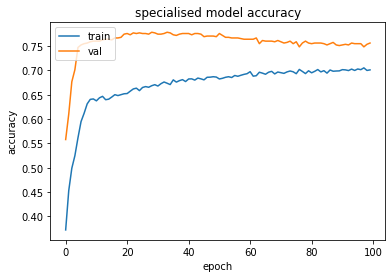

In [45]:
plot_specialised(specialised_history)

In [ ]:
# trained_model = os.path.join(os.path.join(MILESTONE_DIR, 'trained_models'),'specialised_model.h5')
# specialised.save(trained_model)

##### Load Saved Model and Evaluate

In [ ]:
# trained_model = os.path.join(os.path.join(MILESTONE_DIR, 'trained_models'),'specialised_model.h5')
# specialised_model = load_model(trained_model)

Evaluating Prediction Performance

In [46]:
# Generating Inputs

x_test_ohe,y_test = generate_inputs(vec_test,args,indexes,experiment)

# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")

results = specialised.evaluate(x_test_ohe, y_test, batch_size=100)
y_pred = specialised.predict(x_test_ohe)
print("test loss, test acc:", results)

Evaluate on test data
69/69 [==============================] - 3s 6ms/step
test loss, test acc: [0.927918553352356, 0.6648401618003845]


In [47]:
target_names = [index_ne[i] for i in range(len(index_ne))]

print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1), target_names=target_names))

                             precision    recall  f1-score   support

       A_APPROVED_ACTIVATED       0.00      0.00      0.00        74
       A_CANCELLED_DECLINED       0.37      0.21      0.27       308
       O_CANCELLED_DECLINED       0.36      0.16      0.22       383
                O_SENT_BACK       0.69      0.88      0.78       797
W_Assessing the application       0.76      1.00      0.86       628

                   accuracy                           0.66      2190
                  macro avg       0.44      0.45      0.43      2190
               weighted avg       0.58      0.66      0.61      2190



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Confusion Matrix

[[  0   0   0   0  74]
 [  0  66  54 132  56]
 [  0  74  60 178  71]
 [  0  36  55 705   1]
 [  0   1   0   2 625]]


<Axes: >

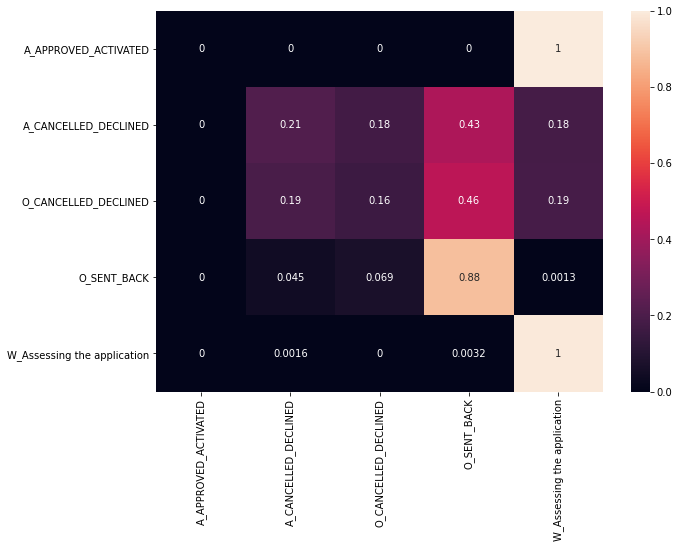

In [48]:
matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print(matrix)
matrix_sum = np.sum(matrix, axis=1).reshape(-1,1)
matrix_perc = matrix / matrix_sum
df_cm = pd.DataFrame(matrix_perc, index = [index_ne[i] for i in range(len(index_ne))],
                  columns = [index_ne[i] for i in range(len(index_ne))])

plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

##### Generating Explanations with Attention Layer

In [49]:
model_attn_weights = Model(inputs=specialised.input,
              outputs=[specialised.output, specialised.get_layer('timestep_attention').output,specialised.get_layer('ac_importance').output ,specialised.get_layer('rl_importance').output,specialised.get_layer('t_importance').output])

output_with_attention = model_attn_weights.predict(x_test_ohe)

69/69 [==============================] - 3s 6ms/step


###### Global Explanations

In [50]:
explain_global(output_with_attention,x_test,y_test,index_ac, index_rl,3,prediction=2)

###### Local Explanations

In [51]:
df_results = results_df(y_test,y_pred,index_ne)
df_results [(df_results ['prediction'] == 'W_Assessing the application') & (df_results ['pred_class'] == True) & (df_results ['prediction_prob'] >=0.7) ].head(3)

sample_index                   prediction                 ground_truth  \
3              3  W_Assessing the application  W_Assessing the application   
15            15  W_Assessing the application  W_Assessing the application   
23            23  W_Assessing the application  W_Assessing the application   

    prediction_prob  pred_class  
3            0.7572        True  
15           0.7397        True  
23           0.7622        True

In [52]:
explain_local(output_with_attention,x_test,y_test,index_ac,index_rl,index_ne,3,53)

prediction: O_SENT_BACK
ground truth: O_CANCELLED_DECLINED
prediction probability:0.6555


process flowchart
st6=>start: start O_SENT
op7=>operation: W_Filling in information for the application_role_11169
op8=>operation: W_Calling after sent offers_role_11119
op9=>operation: W_Calling after sent offers_role_11119
op10=>operation: W_Calling after sent offers_role_10982

st6->op7
op7->op8
op8->op9
op9->op10



